In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'absolute'
model_name = 'distilbert'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6273228246264342 	 Validation loss: 0.4496995584439423 	 
  1%|          | 574/57400 [02:48<4:25:04,  3.57it/s]
Epoch 2 	 Training loss: 0.4053359927823735 	 Validation loss: 0.361918059951168 	 
  2%|▏         | 1148/57400 [05:38<4:34:57,  3.41it/s]
Epoch 3 	 Training loss: 0.35817840560388065 	 Validation loss: 0.34510836510334986 	 
  3%|▎         | 1722/57400 [08:30<4:35:17,  3.37it/s]
Epoch 4 	 Training loss: 0.3376885946152102 	 Validation loss: 0.3322857332936788 	 
  4%|▍         | 2296/57400 [11:55<4:24:02,  3.48it/s]
Epoch 5 	 Training loss: 0.3233801588312259 	 Validation loss: 0.3255870647854724 	 
  5%|▌         | 2870/57400 [15:15<4:13:27,  3.59it/s]
Epoch 6 	 Training loss: 0.31285825763741437 	 Validation loss: 0.31991656528691115 	 
  6%|▌         | 3444/57400 [18:05<4:22:58,  3.42it/s]
Epoch 7 	 Training loss: 0.3035970815953893 	 Validation loss: 0.31419024477570745 	 
  7%|▋         | 4018/57400 [20:55<4:23:26,  3.38it/s]
Epoch 8 	 Trainin

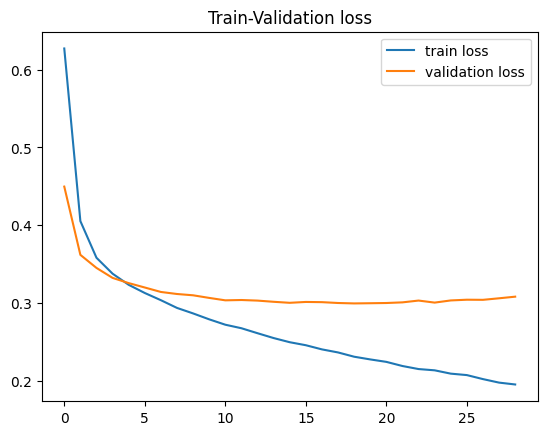

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8425, 'male': 0.8463541666666666, 'average': 0.8444270833333334}
precision {'female': 0.851010101010101, 'male': 0.8376288659793815, 'average': 0.8443194834947412}
f1 {'female': 0.8467336683417085, 'male': 0.8419689119170984, 'average': 0.8443512901294035}
accuracy 0.8443877551020408


Evaluación en el conjunto el conjunto to
recall {'female': 0.6535433070866141, 'male': 0.6763990267639902, 'average': 0.6649711669253022}
precision {'female': 0.6518324607329843, 'male': 0.6780487804878049, 'average': 0.6649406206103946}
f1 {'female': 0.6526867627785059, 'male': 0.6772228989037758, 'average': 0.6649548308411408}
accuracy 0.6654040404040404


Evaluación en el conjunto el conjunto as
recall {'female': 0.7223719676549866, 'male': 0.648989898989899, 'average': 0.6856809333224427}
precision {'female': 0.6584766584766585, 'male': 0.7138888888888889, 'average': 0.6861827736827737}
f1 {'female': 0.6889460154241646, 'male': 0.67989

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5760945814307974 	 Validation loss: 0.4127203923160747 	 
  1%|          | 574/57400 [02:52<4:59:55,  3.16it/s]
Epoch 2 	 Training loss: 0.39069613349666166 	 Validation loss: 0.35551757176043625 	 
  2%|▏         | 1148/57400 [06:00<3:36:13,  4.34it/s]
Epoch 3 	 Training loss: 0.35542821933479674 	 Validation loss: 0.33919971827733314 	 
  3%|▎         | 1722/57400 [08:50<4:20:07,  3.57it/s]
Epoch 4 	 Training loss: 0.33789775660748267 	 Validation loss: 0.33023603184748507 	 
  4%|▍         | 2296/57400 [11:42<4:55:42,  3.11it/s]
Epoch 5 	 Training loss: 0.32487598204342744 	 Validation loss: 0.32528929664927014 	 
  5%|▌         | 2870/57400 [14:41<3:41:00,  4.11it/s]
Epoch 6 	 Training loss: 0.31258764377558274 	 Validation loss: 0.3180584452920041 	 
  6%|▌         | 3444/57400 [17:16<3:43:01,  4.03it/s]
Epoch 7 	 Training loss: 0.3029906988299682 	 Validation loss: 0.31389841588877015 	 
  7%|▋         | 4018/57400 [19:41<2:59:42,  4.95it/s]
Epoch 8 	 T

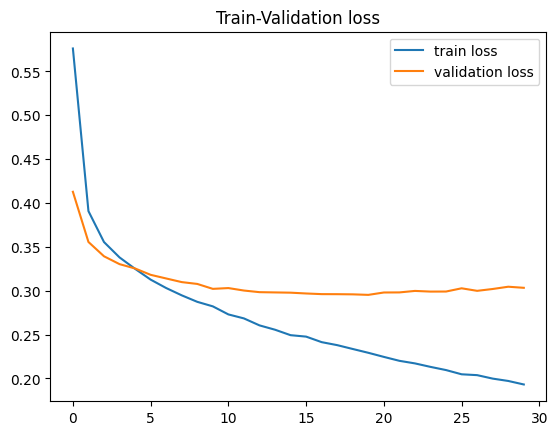

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p =train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [20]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.82, 'male': 0.8489583333333334, 'average': 0.8344791666666667}
precision {'female': 0.8497409326424871, 'male': 0.8190954773869347, 'average': 0.8344182050147109}
f1 {'female': 0.8346055979643766, 'male': 0.8337595907928389, 'average': 0.8341825943786078}
accuracy 0.8341836734693877


Evaluación en el conjunto el conjunto to
recall {'female': 0.6246719160104987, 'male': 0.6958637469586375, 'average': 0.660267831484568}
precision {'female': 0.6556473829201102, 'male': 0.6666666666666666, 'average': 0.6611570247933884}
f1 {'female': 0.6397849462365591, 'male': 0.6809523809523809, 'average': 0.66036866359447}
accuracy 0.6616161616161617


Evaluación en el conjunto el conjunto as
recall {'female': 0.7088948787061995, 'male': 0.6691919191919192, 'average': 0.6890433989490594}
precision {'female': 0.6675126903553299, 'male': 0.710455764075067, 'average': 0.6889842272151985}
f1 {'female': 0.6875816993464052, 'male': 0.689206762

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5712320729830539 	 Validation loss: 0.4120359269239135 	 
  1%|          | 574/57400 [03:29<4:45:05,  3.32it/s]
Epoch 2 	 Training loss: 0.3899106492356556 	 Validation loss: 0.3622823797040067 	 
  2%|▏         | 1148/57400 [06:59<4:26:42,  3.52it/s]
Epoch 3 	 Training loss: 0.35265606997424304 	 Validation loss: 0.3387083779957335 	 
  3%|▎         | 1722/57400 [10:29<4:27:55,  3.46it/s]
Epoch 4 	 Training loss: 0.3331642455911387 	 Validation loss: 0.3299372542207524 	 
  4%|▍         | 2296/57400 [13:03<3:57:09,  3.87it/s]
Epoch 5 	 Training loss: 0.32069514484147993 	 Validation loss: 0.3222443327560263 	 
  5%|▌         | 2870/57400 [15:30<4:25:30,  3.42it/s]
Epoch 6 	 Training loss: 0.30895439335485786 	 Validation loss: 0.32142670023239267 	 
  6%|▌         | 3444/57400 [17:56<3:48:48,  3.93it/s]
Epoch 7 	 Training loss: 0.3003533175182675 	 Validation loss: 0.3124497381307311 	 
  7%|▋         | 4018/57400 [20:22<3:01:45,  4.90it/s]
Epoch 8 	 Trainin

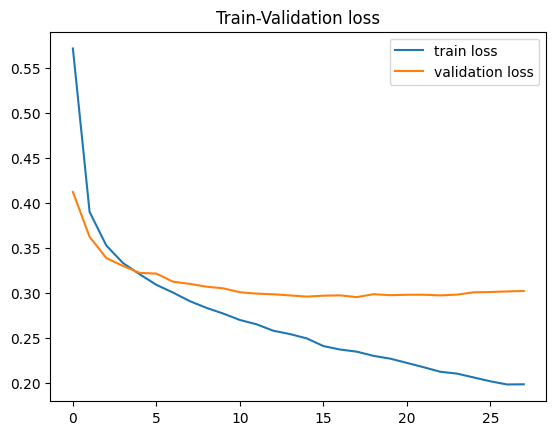

In [21]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [22]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.83, 'male': 0.8541666666666666, 'average': 0.8420833333333333}
precision {'female': 0.8556701030927835, 'male': 0.8282828282828283, 'average': 0.8419764656878059}
f1 {'female': 0.8426395939086294, 'male': 0.8410256410256411, 'average': 0.8418326174671353}
accuracy 0.8418367346938775


Evaluación en el conjunto el conjunto to
recall {'female': 0.6272965879265092, 'male': 0.6982968369829684, 'average': 0.6627967124547388}
precision {'female': 0.6584022038567493, 'male': 0.668997668997669, 'average': 0.6636999364272091}
f1 {'female': 0.6424731182795699, 'male': 0.6833333333333333, 'average': 0.6629032258064516}
accuracy 0.6641414141414141


Evaluación en el conjunto el conjunto as
recall {'female': 0.6900269541778976, 'male': 0.6742424242424242, 'average': 0.682134689210161}
precision {'female': 0.6649350649350649, 'male': 0.6989528795811518, 'average': 0.6819439722581084}
f1 {'female': 0.6772486772486772, 'male': 0.6863753

Resultados finales

In [23]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8401221673250489
f1 etiqueta male: 0.8389180479118595
f1 etiqueta female:  0.8413262867382382


TO
Resultado global f1: 0.6627422400806875
f1 etiqueta male: 0.6805028710631633
f1 etiqueta female:  0.6449816090982117


AS
Resultado global f1: 0.684875442546466
f1 etiqueta male: 0.6851587544198499
f1 etiqueta female:  0.6845921306730823


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8401221673250489
recall etiqueta male: 0.8389180479118595
recall etiqueta female:  0.8413262867382382


TO
Resultado global recall: 0.6627422400806875
recall etiqueta male: 0.6805028710631633
recall etiqueta female:  0.6449816090982117


AS
Resultado global recall: 0.684875442546466
recall etiqueta male: 0.6851587544198499
recall etiqueta female:  0.6845921306730823


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8401221673250489
precision etiqueta male: 0.8389180479118595
precision etiqueta female:  0.841

# TO

In [24]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [25]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6954898915224375 	 Validation loss: 0.6954727890127796 	 
  1%|          | 574/57400 [02:25<3:58:00,  3.98it/s]
Epoch 2 	 Training loss: 0.6949111530589726 	 Validation loss: 0.693082183094348 	 
  2%|▏         | 1148/57400 [04:50<3:49:29,  4.09it/s]
Epoch 3 	 Training loss: 0.6949011626351586 	 Validation loss: 0.6939020338705031 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [07:15<2:59:40,  5.16it/s]
Epoch 4 	 Training loss: 0.6943819860340411 	 Validation loss: 0.69207716089184 	 
  4%|▍         | 2296/57400 [09:40<3:55:09,  3.91it/s]
Epoch 5 	 Training loss: 0.6941931621538222 	 Validation loss: 0.6932375087576398 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [12:05<3:01:27,  5.01it/s]
Epoch 6 	 Training loss: 0.6939409807168648 	 Validation loss: 0.6919952348127203 	 
  6%|▌         | 3444/57400 [14:30<3:48:20,  3.94it/s]
Epoch 7 	 Training loss: 0.6938078133486705 	 Validation loss: 0.6929497759220964 	 

1 epoch without impr

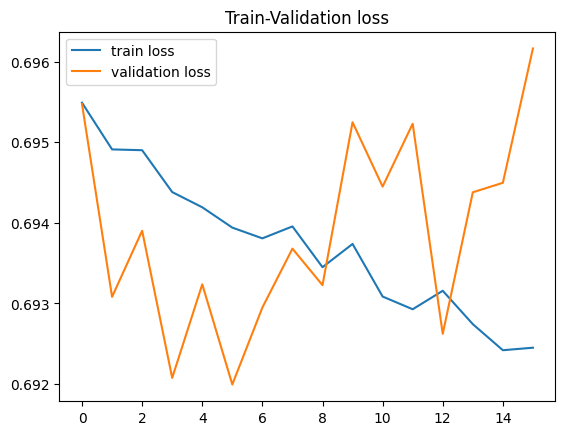

In [26]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [27]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.98, 'male': 0.09895833333333333, 'average': 0.5394791666666666}
precision {'female': 0.5311653116531165, 'male': 0.8260869565217391, 'average': 0.6786261340874278}
f1 {'female': 0.6889279437609842, 'male': 0.17674418604651163, 'average': 0.43283606490374793}
accuracy 0.548469387755102


Evaluación en el conjunto el conjunto to
recall {'female': 0.9343832020997376, 'male': 0.10948905109489052, 'average': 0.521936126597314}
precision {'female': 0.4930747922437673, 'male': 0.6428571428571429, 'average': 0.5679659675504551}
f1 {'female': 0.6455122393472348, 'male': 0.18711018711018712, 'average': 0.41631121322871095}
accuracy 0.5063131313131313


Evaluación en el conjunto el conjunto as
recall {'female': 0.9568733153638814, 'male': 0.09090909090909091, 'average': 0.5238912031364862}
precision {'female': 0.4965034965034965, 'male': 0.6923076923076923, 'average': 0.5944055944055944}
f1 {'female': 0.6537753222836096, 'male': 0.

In [28]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6963018145710749 	 Validation loss: 0.6936297214637368 	 
  1%|          | 574/57400 [02:25<3:58:28,  3.97it/s]
Epoch 2 	 Training loss: 0.6952193558008414 	 Validation loss: 0.6929170125621861 	 
  2%|▏         | 1148/57400 [04:50<3:53:36,  4.01it/s]
Epoch 3 	 Training loss: 0.6947959761170975 	 Validation loss: 0.6935996211181252 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [07:15<3:50:12,  4.03it/s]
Epoch 4 	 Training loss: 0.6940639864276926 	 Validation loss: 0.6922902525481531 	 
  4%|▍         | 2296/57400 [09:40<3:53:30,  3.93it/s]
Epoch 5 	 Training loss: 0.6943894467910408 	 Validation loss: 0.6924354130938902 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [12:05<3:35:13,  4.22it/s]
Epoch 6 	 Training loss: 0.693861898021831 	 Validation loss: 0.6925353003760516 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [14:30<4:57:55,  3.02it/s]
Epoch 7 	 Training loss: 0.693918729908375 	 Validation loss: 0.69358415724

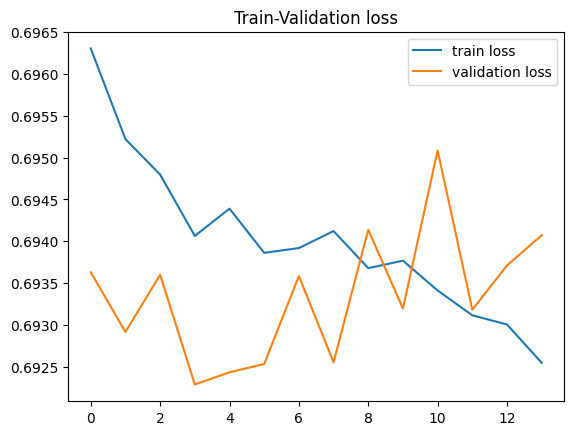

In [29]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [30]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.5775, 'male': 0.5182291666666666, 'average': 0.5478645833333333}
precision {'female': 0.5552884615384616, 'male': 0.5407608695652174, 'average': 0.5480246655518395}
f1 {'female': 0.5661764705882353, 'male': 0.5292553191489361, 'average': 0.5477158948685856}
accuracy 0.548469387755102


Evaluación en el conjunto el conjunto to
recall {'female': 0.6482939632545932, 'male': 0.4306569343065693, 'average': 0.5394754487805813}
precision {'female': 0.5135135135135135, 'male': 0.5691318327974276, 'average': 0.5413226731554706}
f1 {'female': 0.5730858468677493, 'male': 0.4903047091412742, 'average': 0.5316952780045118}
accuracy 0.5353535353535354


Evaluación en el conjunto el conjunto as
recall {'female': 0.6873315363881402, 'male': 0.39646464646464646, 'average': 0.5418980914263933}
precision {'female': 0.5161943319838057, 'male': 0.575091575091575, 'average': 0.5456429535376903}
f1 {'female': 0.5895953757225434, 'male': 0.4693

In [31]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.696837595946282 	 Validation loss: 0.6926804457680654 	 
  1%|          | 574/57400 [02:26<4:04:09,  3.88it/s]
Epoch 2 	 Training loss: 0.695416260990947 	 Validation loss: 0.6932382512900789 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:52<3:50:11,  4.07it/s]
Epoch 3 	 Training loss: 0.6953502825951327 	 Validation loss: 0.6936092609066075 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [07:19<3:14:19,  4.78it/s]
Epoch 4 	 Training loss: 0.6947344453284965 	 Validation loss: 0.6935366543672853 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [09:45<3:00:43,  5.08it/s]
Epoch 5 	 Training loss: 0.6939588115398061 	 Validation loss: 0.6923907409280033 	 
  5%|▌         | 2870/57400 [12:12<3:49:56,  3.95it/s]
Epoch 6 	 Training loss: 0.6943290940768212 	 Validation loss: 0.694397252495006 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [14:38<3:00:59,  4.97it/s]
Epoch 7 	 Training loss: 0.6940259451650161 	 Va

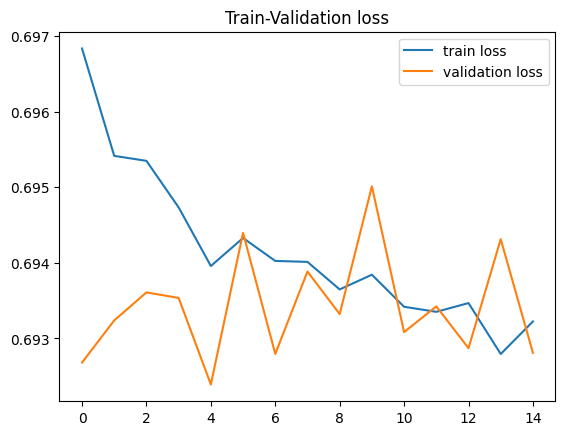

In [32]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [33]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8975, 'male': 0.09635416666666667, 'average': 0.4969270833333333}
precision {'female': 0.5084985835694051, 'male': 0.47435897435897434, 'average': 0.49142877896418974}
f1 {'female': 0.6491862567811935, 'male': 0.1601731601731602, 'average': 0.4046797084771768}
accuracy 0.5051020408163265


Evaluación en el conjunto el conjunto to
recall {'female': 0.905511811023622, 'male': 0.1411192214111922, 'average': 0.5233155162174071}
precision {'female': 0.49426934097421205, 'male': 0.6170212765957447, 'average': 0.5556453087849784}
f1 {'female': 0.6394810009267841, 'male': 0.2297029702970297, 'average': 0.4345919856119069}
accuracy 0.5088383838383839


Evaluación en el conjunto el conjunto as
recall {'female': 0.9029649595687331, 'male': 0.12373737373737374, 'average': 0.5133511666530535}
precision {'female': 0.4912023460410557, 'male': 0.5764705882352941, 'average': 0.5338364671381749}
f1 {'female': 0.6362773029439696, 'male': 0

Resultados finales

In [34]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.46174388941650346
f1 etiqueta male: 0.28872422178953594
f1 etiqueta female:  0.634763557043471


TO
Resultado global f1: 0.4608661589483765
f1 etiqueta male: 0.30237262218283034
f1 etiqueta female:  0.6193596957139227


AS
Resultado global f1: 0.45224362333881996
f1 etiqueta male: 0.2779379130275991
f1 etiqueta female:  0.6265493336500408


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.46174388941650346
recall etiqueta male: 0.28872422178953594
recall etiqueta female:  0.634763557043471


TO
Resultado global recall: 0.4608661589483765
recall etiqueta male: 0.30237262218283034
recall etiqueta female:  0.6193596957139227


AS
Resultado global recall: 0.45224362333881996
recall etiqueta male: 0.2779379130275991
recall etiqueta female:  0.6265493336500408


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.46174388941650346
precision etiqueta male: 0.28872422178953594
precision etiqueta fema

# AS

In [35]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [36]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955109666448852 	 Validation loss: 0.6930750547829321 	 
  1%|          | 574/57400 [02:26<4:02:23,  3.91it/s]
Epoch 2 	 Training loss: 0.6929714158436978 	 Validation loss: 0.6920222640037537 	 
  2%|▏         | 1148/57400 [04:53<3:57:37,  3.95it/s]
Epoch 3 	 Training loss: 0.6921413724638443 	 Validation loss: 0.6919528427770583 	 
  3%|▎         | 1722/57400 [07:20<3:05:39,  5.00it/s]
Epoch 4 	 Training loss: 0.6911369274509909 	 Validation loss: 0.691901641376948 	 
  4%|▍         | 2296/57400 [09:47<3:49:51,  4.00it/s]
Epoch 5 	 Training loss: 0.6897196346043709 	 Validation loss: 0.69191638493942 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [12:13<3:51:37,  3.92it/s]
Epoch 6 	 Training loss: 0.6882624047766164 	 Validation loss: 0.6930916723558458 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [14:39<3:44:28,  4.01it/s]
Epoch 7 	 Training loss: 0.68718221046368 	 Validation loss: 0.6909904085983665 	 
  7%|▋         | 4018/5

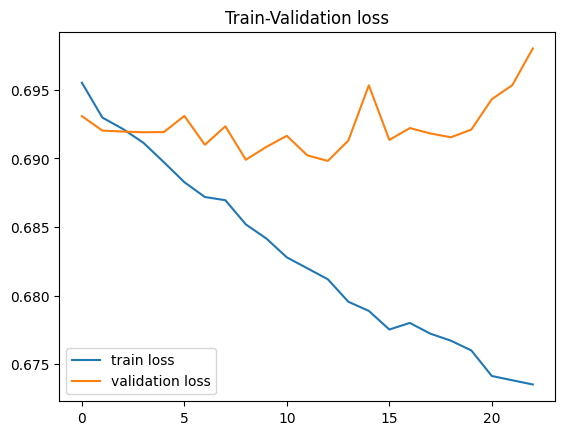

In [37]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [38]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.7225, 'male': 0.6302083333333334, 'average': 0.6763541666666667}
precision {'female': 0.6705336426914154, 'male': 0.6855524079320113, 'average': 0.6780430253117133}
f1 {'female': 0.6955475330926595, 'male': 0.6567164179104478, 'average': 0.6761319755015536}
accuracy 0.6772959183673469


Evaluación en el conjunto el conjunto to
recall {'female': 0.6850393700787402, 'male': 0.6763990267639902, 'average': 0.6807191984213652}
precision {'female': 0.6624365482233503, 'male': 0.6984924623115578, 'average': 0.6804645052674541}
f1 {'female': 0.6735483870967742, 'male': 0.6872682323856614, 'average': 0.6804083097412178}
accuracy 0.6805555555555556


Evaluación en el conjunto el conjunto as
recall {'female': 0.7816711590296496, 'male': 0.6565656565656566, 'average': 0.7191184077976531}
precision {'female': 0.6807511737089202, 'male': 0.7624633431085044, 'average': 0.7216072584087123}
f1 {'female': 0.7277289836888332, 'male': 0.705

In [39]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6947731441114007 	 Validation loss: 0.6916955062898539 	 
  1%|          | 574/57400 [02:26<4:11:31,  3.77it/s]
Epoch 2 	 Training loss: 0.6932891071465788 	 Validation loss: 0.6927258311691931 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:53<4:51:52,  3.21it/s]
Epoch 3 	 Training loss: 0.6913638611288436 	 Validation loss: 0.6917506143198175 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [07:19<3:58:07,  3.90it/s]
Epoch 4 	 Training loss: 0.6903343613970155 	 Validation loss: 0.6920473484669701 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [09:45<3:43:04,  4.12it/s]
Epoch 5 	 Training loss: 0.6883241322397771 	 Validation loss: 0.6942096504114442 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [12:12<3:47:43,  3.99it/s]
Epoch 6 	 Training loss: 0.6875422560587162 	 Validation loss: 0.6917723962816141 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [14:38<3:47:36,  3.95it/s]
Epoch 7 	 Traini

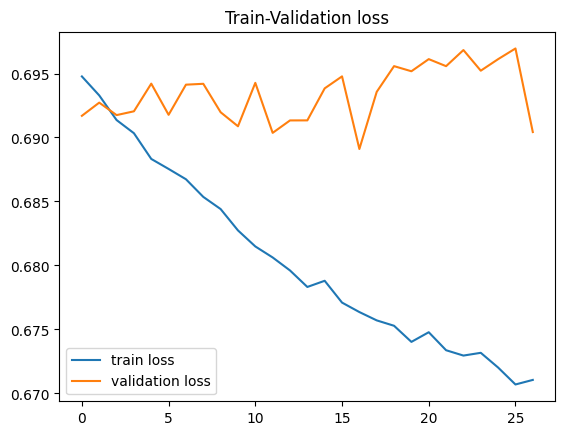

In [40]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [41]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.645, 'male': 0.6302083333333334, 'average': 0.6376041666666667}
precision {'female': 0.645, 'male': 0.6302083333333334, 'average': 0.6376041666666667}
f1 {'female': 0.645, 'male': 0.6302083333333334, 'average': 0.6376041666666667}
accuracy 0.6377551020408163


Evaluación en el conjunto el conjunto to
recall {'female': 0.6640419947506562, 'male': 0.708029197080292, 'average': 0.686035595915474}
precision {'female': 0.67828418230563, 'male': 0.6945107398568019, 'average': 0.686397461081216}
f1 {'female': 0.6710875331564987, 'male': 0.7012048192771084, 'average': 0.6861461762168035}
accuracy 0.6868686868686869


Evaluación en el conjunto el conjunto as
recall {'female': 0.7735849056603774, 'male': 0.6818181818181818, 'average': 0.7277015437392795}
precision {'female': 0.6949152542372882, 'male': 0.7627118644067796, 'average': 0.728813559322034}
f1 {'female': 0.7321428571428573, 'male': 0.7199999999999999, 'average': 0.72607

In [42]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.7054457506651662 	 Validation loss: 0.6953388442427425 	 
  1%|          | 574/57400 [02:26<3:55:15,  4.03it/s]
Epoch 2 	 Training loss: 0.7041810922298697 	 Validation loss: 0.6985524872602042 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:53<3:58:25,  3.93it/s]
Epoch 3 	 Training loss: 0.7052269695320196 	 Validation loss: 0.6933372111643775 	 
  3%|▎         | 1722/57400 [07:20<4:01:33,  3.84it/s]
Epoch 4 	 Training loss: 0.7038747349474903 	 Validation loss: 0.6954524678699041 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [09:47<3:52:52,  3.94it/s]
Epoch 5 	 Training loss: 0.7045468965266224 	 Validation loss: 0.6943054865982573 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [12:14<3:07:03,  4.86it/s]
Epoch 6 	 Training loss: 0.7042899505601943 	 Validation loss: 0.6981476272566843 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [14:41<4:29:01,  3.34it/s]
Epoch 7 	 Training loss: 0.7037626344983171 	

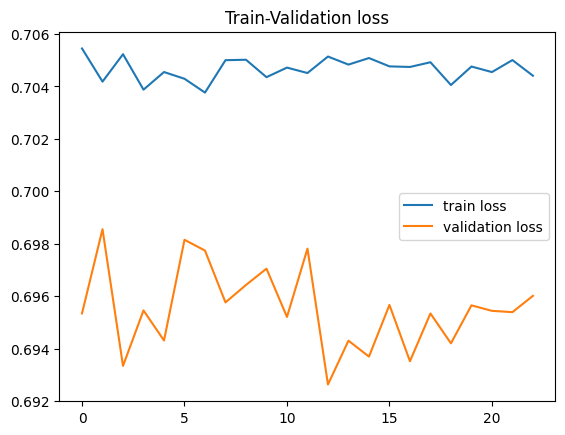

In [43]:
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [44]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.995, 'male': 0.0026041666666666665, 'average': 0.4988020833333333}
precision {'female': 0.5096030729833547, 'male': 0.3333333333333333, 'average': 0.421468203158344}
f1 {'female': 0.6740050804403048, 'male': 0.005167958656330749, 'average': 0.3395865195483178}
accuracy 0.5089285714285714


Evaluación en el conjunto el conjunto to
recall {'female': 0.9921259842519685, 'male': 0.0024330900243309003, 'average': 0.4972795371381497}
precision {'female': 0.4796954314720812, 'male': 0.25, 'average': 0.3648477157360406}
f1 {'female': 0.6467065868263473, 'male': 0.004819277108433735, 'average': 0.32576293196739053}
accuracy 0.47853535353535354


Evaluación en el conjunto el conjunto as
recall {'female': 0.9973045822102425, 'male': 0.015151515151515152, 'average': 0.5062280486808789}
precision {'female': 0.4868421052631579, 'male': 0.8571428571428571, 'average': 0.6719924812030075}
f1 {'female': 0.654288240495137, 'male': 0.029776

Resultados finales

In [45]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5511075539055127
f1 etiqueta male: 0.43069756996670394
f1 etiqueta female:  0.6715175378443214


TO
Resultado global f1: 0.5641058059751373
f1 etiqueta male: 0.46443077625706786
f1 etiqueta female:  0.6637808356932068


AS
Resultado global f1: 0.5949166416479313
f1 etiqueta male: 0.4851132561869201
f1 etiqueta female:  0.7047200271089425


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5511075539055127
recall etiqueta male: 0.43069756996670394
recall etiqueta female:  0.6715175378443214


TO
Resultado global recall: 0.5641058059751373
recall etiqueta male: 0.46443077625706786
recall etiqueta female:  0.6637808356932068


AS
Resultado global recall: 0.5949166416479313
recall etiqueta male: 0.4851132561869201
recall etiqueta female:  0.7047200271089425


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5511075539055127
precision etiqueta male: 0.43069756996670394
precision etiqueta female: